In [1]:
### The function below accepts an event ID as a string
### as well as the desired station and network as strings and
### produces a figure showing the noise and signal (power) spectra 
### corresponding to that event at the specified station

In [4]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
import os
import mtspec
from obspy.core import read
from obspy import UTCDateTime
from mtspec import mtspec
from collections import defaultdict
import matplotlib.gridspec as gridspec

In [269]:
def stack_spec(evlist, network, station):
    
    # figure parameters
    fig = plt.figure(figsize=(10,6), constrained_layout=True)
    gs = gridspec.GridSpec(4, 2)
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # define directories
    work_dir = "/Volumes/T7/"
    ph_dir = work_dir + "SWS/Data/SWS_data/phase/"
    fig_dir = work_dir + "SWS/Data/SWS_data/figs/spectra/"
    wf_dir = work_dir + "SWS/Data/SWS_data/wf/"
    
    # define dictionary for data to be added
    # key: evid, value: stream
    data = {}
    
    # read waveform data into data dictionary
    for i in range(len(evlist)):
        data[evlist[i]] = read(wf_dir + str(evlist[i]) + 
                              "/" + str(evlist[i]) + "." + network
                               + "." + station + ".*.mseed")
        
    # read in phase data to dictionary "windows"
    # to get signal & noise windows
    windows = {}
    for event in evlist:
        with open(ph_dir+str(event)+'.phase', 'r') as f:
            # loop over lines
            line_count = 0
            for line in f:
                # parse
                temp = line.split()
                # get event magnitude and otime from header
                if line_count == 0:
                    mag = float(temp[7])
                    otime = UTCDateTime(temp[3])
                # store S and P picks and determine windows
                # windows are magnitude-dependent
                if line_count > 0:
                    sta = temp[1]
                    if sta != station:
                        continue
                    phase = temp[7]
                    if phase == "P":
                        ppick = float(temp[12])
                        stno = otime + ppick - 0.9*ppick
                        endno = stno + (0.3 + 0.2*(mag - 1.0))
                    if phase != "S":
                        continue
                    if phase == "S":
                        spick = float(temp[12])
                        stsig = otime + spick
                        endsig = stsig + (0.3 + 0.2*(mag - 1.0))                        
                line_count += 1
                
        # store signal and noise window start and end time
        windows[event] = {'stsig': stsig, 'endsig': endsig, 
                         'stno': stno, 'endno': endno, 'otime': otime}
        
    # window data & stack traces
    # loop over events
    for event, stream in data.items():
        sig = defaultdict(list)
        no = defaultdict(list)
        spec_sig = defaultdict(list)
        spec_no = defaultdict(list)
        
        # loop over channels in that event
        for trace in range(len(stream)):
            # exclude Z component
            if stream[trace].stats.channel not in ['HHE','HHN','EH1','EH2']:
                continue
            
            # detrend & taper data
            stream[trace].detrend("linear")
            stream[trace].detrend("demean")
            stream[trace].taper(max_percentage=0.05, type="hann")
            
            # window times using otime and windows dictionary
            t = stream[trace].times("utcdatetime")
            sigrange = (t > windows[event]['stsig']) & (t <= windows[event]['endsig'])
            t_sig = t[sigrange]
            
            norange = (t > windows[event]['stno']) & (t <= windows[event]['endno'])
            t_no = t[norange]

            # window data using time window and
            # center each channel around zero (demean again)
            sig[stream[trace].stats.channel].append(
                stream[trace].data[sigrange].astype("float"))
            sig[stream[trace].stats.channel] -= np.mean(sig[stream[trace].stats.channel])

            no[stream[trace].stats.channel].append(
                stream[trace].data[norange].astype("float"))
            no[stream[trace].stats.channel] -= np.mean(no[stream[trace].stats.channel])
            
            # plot channel time series
            
            ymax = np.max(stream[trace].data) + np.max(stream[trace].data)
            ymin = np.min(stream[trace].data) - 0.2*abs(np.min(stream[trace].data))
            
            ch_pl = fig.add_subplot(gs[trace,:])
            ch_pl.plot(t, stream[trace].data, color='black')
            ch_pl.plot(t_sig, stream[trace].data[sigrange], color='cornflowerblue', label="Signal")
            ch_pl.plot(t_no, stream[trace].data[norange], color='chocolate', label="Noise", linewidth=3)
            ch_pl.set_xlim(t[0].timestamp,t[-1].timestamp-20)
            ch_pl.set_ylim(ymin,ymax)
            ch_pl.set_title(f'Channel {stream[trace].stats.channel}')
            ch_pl.legend(loc="upper left")
            
            # calculate spectrum of signal and noise
            spec, freq, jackknife, _, _ = mtspec(data=sig[stream[trace].stats.channel][-1],
                                                 delta=stream[trace].stats.delta,
                                                 time_bandwidth=3, statistics=True)
            
            spec_sig[stream[trace].stats.channel].append(freq)
            spec_sig[stream[trace].stats.channel].append(spec)
            sig_freq = freq
            sig_diff = sig_freq[1] - sig_freq[0]
            
            spec, freq, jackknife, _, _ = mtspec(data=no[stream[trace].stats.channel][-1],
                                                 delta=stream[trace].stats.delta,
                                                 time_bandwidth=3, statistics=True)
            
            spec_no[stream[trace].stats.channel].append(freq)
            spec_no[stream[trace].stats.channel].append(spec)
            no_freq = freq
            no_diff = no_freq[1] - no_freq[0]
        
        # stack trace spectra (magnitude of E/N channels)
        # for both signal and noise
        sig_mag = []
        for i in range(len(spec_sig[stream[0].stats.channel][1])): 
            sig_mag.append(np.sqrt(spec_sig[stream[0].stats.channel][1][i]**2 + 
                                      spec_sig[stream[1].stats.channel][1][i]**2))
        spec_sig['stacked'].append(sig_mag)
        
        no_mag = []
        for i in range(len(spec_no[stream[0].stats.channel][1])): 
            no_mag.append(np.sqrt(spec_no[stream[0].stats.channel][1][i]**2 + 
                                      spec_no[stream[1].stats.channel][1][i]**2))
        spec_no['stacked'].append(no_mag)
    
    # assign signal/noise
    signal = spec_sig['stacked'][0]
    noise = spec_no['stacked'][0]
    
    # optional conversion from PSD to amplitude
#     for i in range(len(signal)):
#         signal[i] = np.sqrt(signal[i]/sig_diff)
#     for i in range(len(noise)):
#         noise[i] = np.sqrt(noise[i]/no_diff)
    
    # get sig/noise ratio
    ratio = []
    for i in range(len(signal)):
        ratio.append(signal[i]/noise[i])
    
    # plot spectra
    ax1 = fig.add_subplot(gs[2:,0])
    ax1.plot(sig_freq, signal,color='cornflowerblue', label="Signal")
    ax1.plot(no_freq, noise, color='chocolate', label="Noise")
    ax1.set_yscale("log")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Power Spectral Density")
    ax1.set_xlim(0,30)
    ax1.set_ylim(1e-2,1e9)
    ax1.set_title("Stacked E/N spectra")
    ax1.legend()

    ax2 = fig.add_subplot(gs[2:,1])
    ax2.plot(sig_freq, np.ones(len(sig_freq)), color="slategray", linestyle="dotted")
    ax2.plot(sig_freq, ratio, color='olivedrab')
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Ratio")
    ax2.set_xlim(0,30)
    ax2.set_yscale("log")
    #ax2.set_ylim(1e0,1e4)
    ax2.set_title("S/N ratio")
    
    # more figure parameters
    plt.tight_layout()
    ax1.grid(True, which="both")
    ax2.grid(True, which="both")
    title = fig.suptitle(f"Spectra for event {evlist[0]}, magnitude {mag}, station {station}", y=1.05)
    
    # store figure
    fig.savefig(fig_dir + "sn_spectra.png", bbox_inches='tight', bbox_extra_artists=[title])

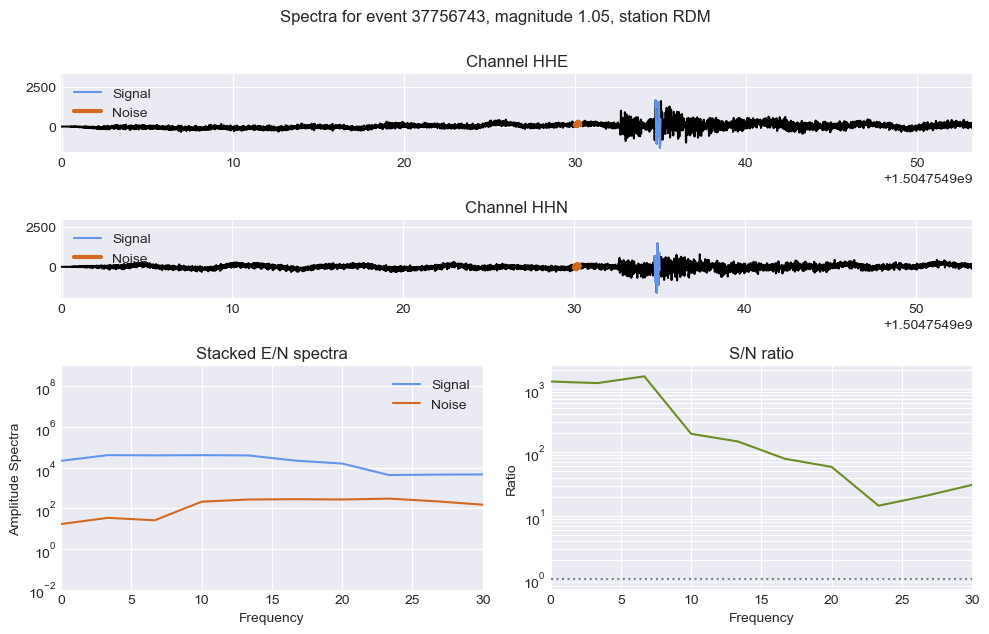

In [277]:
# execute function

evids = ['37756743']
stack_spec(evids,'AZ','RDM')